In [1]:
import pickle
import argparse
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import glob

from main import main

## Run Iterated Learning Base Experiments

In [3]:
seeds = [1, 2, 3, 4, 5]

#train size split experiments (testing the impact of the size of the transmission set on language)
for t in ['0.3', '0.4', '0.5', '0.6', '0.7']:
    for s in seeds:
        main(['--seed', str(s), '--iterations', '1000', '--generations', '200', '--train-size', t, '--resume', '--hidden-size', '256'])

# iterations experiments (testing the impact of longer learning on the transmission set on language)
for i in ['500', '1000', '5000', '10000']:
    for s in seeds:
        main(['--seed', str(s), '--iterations', i, '--generations', '200', '--resume', '--hidden-size', '256'])

# hidden experiments (testing the impact of more complex models or higher dim models on language)
for h in ['64', '256', '512']:
    for s in seeds:
         main(['--seed', str(s), '--iterations', '1000', '--generations', '200', '--resume', '--hidden-size', h])


Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Spac

# Get Metrics from Runs

In [4]:
def get_run_name(n):
    h = n.split('_')[2]
    s = n.split('_')[-1]
    i = n.split('_')[6]
    return h+'_'+s+'_'+i
    
# Loading metrics from saved pickles
metrics = {}
for m in glob.glob("runs/*/*/metrics.pkl"):
    run = m.split('/')[1]
    run_name = get_run_name(run)
    if run_name not in metrics:
        metrics[run_name] = {}
    seed = m.split('/')[2]
    metrics[run_name][seed] = pickle.load(open(m, 'rb'))

In [5]:
list(metrics.keys())

['256_0.6_1000',
 '256_0.7_1000',
 '256_0.3_1000',
 '256_0.4_1000',
 '256_0.5_1000']

# *Updates from previous version*

- Calculate RSA metrics between hidden and message and hidden and input.
- Calculate cross generational RSA between messages and between hiddens. 


<s>- added the basic IOU topographic plots 
    - calculates the very basic IOU/jaccard similarity by doing: `len(intersection(message1, message2))/len(union(message1, message2))`
    - uses `1 - IOU` as distance metric between language pairs
    - uses hamming (edit) distance between compositional pairs
<s> - added the jaccard topographic plots
    - uses the `1 - jaccard_score` as the distance metric between language pairs
    - jaccard score is calculated using sk learn with average 'macro': 
        - Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
    - uses hamming (edit) distance between compositional pairs

# Plot Results

In [6]:
def plot_metric(results, metric="test_loss", ylabel=None, show_error=True, 
                savefig=True, figname=None, title=None, ylim=None, a4_dims=(11.7, 8.27)):
    
    ci = 'sd' if show_error else None
    fig, ax = plt.subplots(figsize=a4_dims)
    
    generations = []
    values = []
    run_names = []
    
    for r in list(results.keys()):
        for s in list(results[r].keys()):    
            for g in sorted(list(results[r][s].keys())):
                generations.append(g)
                values.append(results[r][s][g][metric])
                run_names.append(r)
            
    values = np.array(values)
    iterations = np.array(generations)   
      
    d = {'Generations': iterations,'': run_names, metric: values}
    ax = sns.lineplot(ax=ax, x='Generations', y=metric, data=pd.DataFrame(data=d),
                      style='', hue='', 
                      palette=sns.color_palette("Set1", len(list(results.keys()))), ci=ci)
    if title is None:
        title = metric.replace('_', ' ').title()
    ax.set_title(title, fontsize=30)
    plt.show()

# Plot Train Split Results

Here we plot the experiments run when changing the size of the transmission set (train split) in relation to the entire meaning space. Plotted are the 0.1 intervals between 0.3 and 0.7, where a train split of 0.3 represents the case where only 30% of total meaning space is shown during training. 

In [7]:
def get_train_size_keys(a):
    keys = []
    for k in a:
        attributes = k.split('_')
        if int(attributes[0]) == 256 and int(attributes[2]) == 1000:
            keys.append(k)
    return keys

train_size_dict = { k: metrics[k] for k in get_train_size_keys(list(metrics.keys()))}

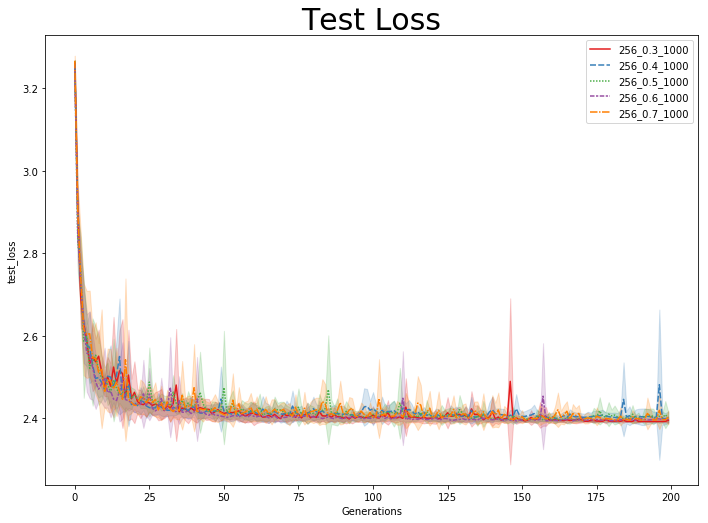

In [8]:
plot_metric(train_size_dict)

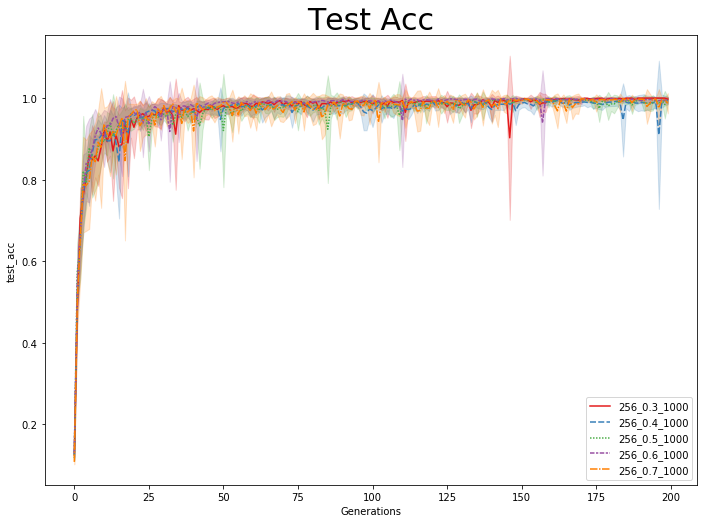

In [9]:
plot_metric(train_size_dict, metric='test_acc')

## RSA Metrics

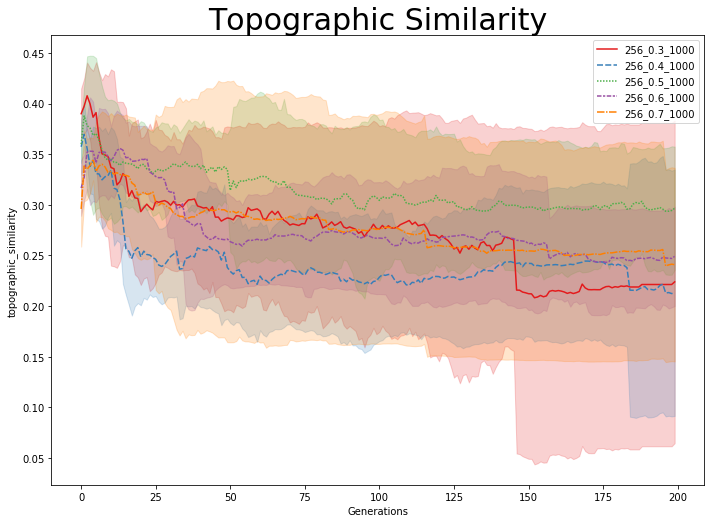

In [16]:
plot_metric(train_size_dict, metric='topographic_similarity') #hamming / hamming

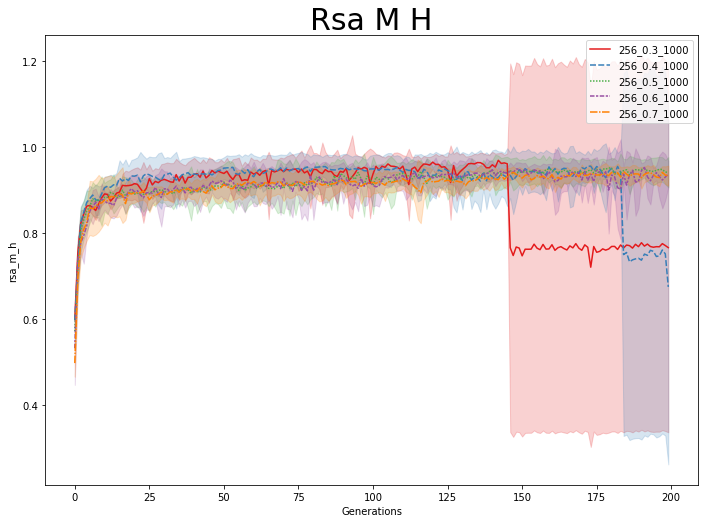

In [13]:
plot_metric(train_size_dict, metric='rsa_m_h') # hamming / cosine

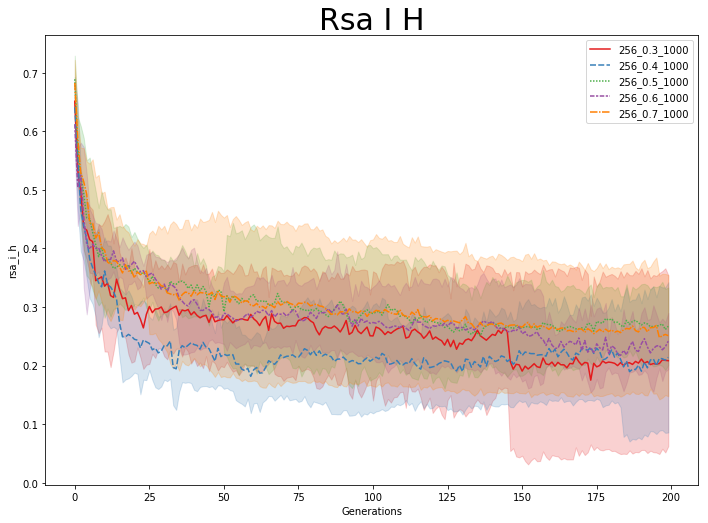

In [15]:
plot_metric(train_size_dict, metric='rsa_i_h') # hamming / cosine

## Cross Generational RSA

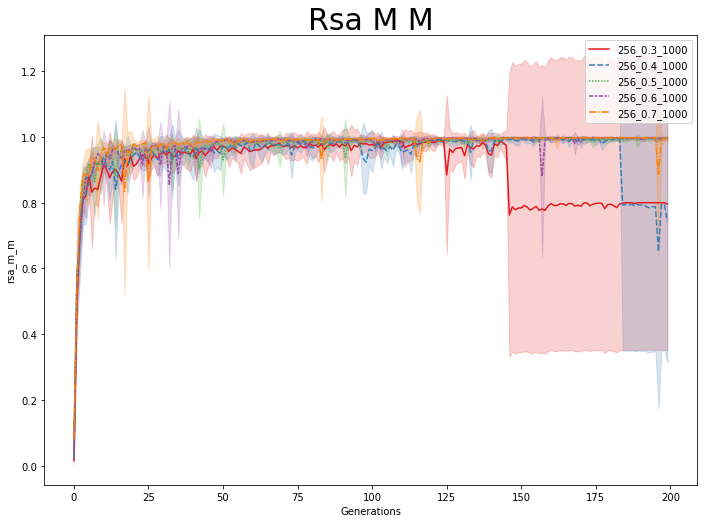

In [11]:
# Cross generational message RSA
plot_metric(train_size_dict, metric='rsa_m_m')  # hamming / hamming

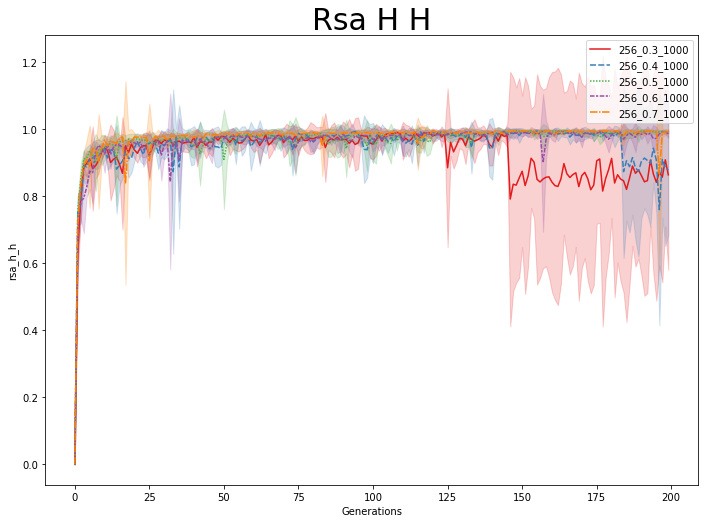

In [12]:
# Cross generational hidden states RSA
plot_metric(train_size_dict, metric='rsa_h_h')  # cosine / cosine

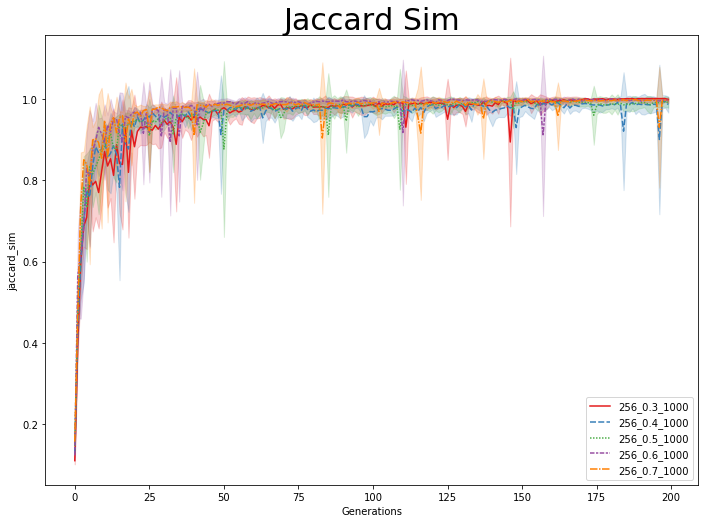

In [18]:
plot_metric(train_size_dict, metric='jaccard_sim')

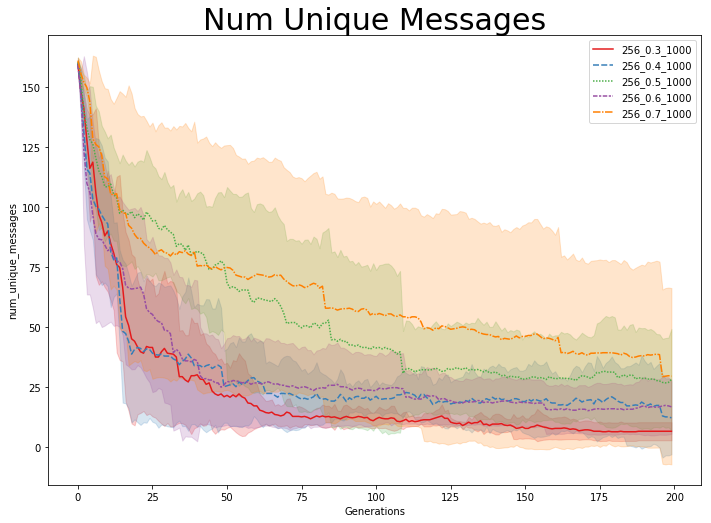

In [17]:
plot_metric(train_size_dict, metric='num_unique_messages')

From these we can conclude that the smaller the transmission set in relation to the original meaning space the less the models will take the input into account.

## Plot Iterations Results

Here we plot the experiments run when changing the size of the iterations that each model is run for at each step of the IL process. Increasing iterations allows for greater learning and overfitting on the transmission set and therefore should allow for a better mapping from inputs to ouputs to be learnt by our model.

In [36]:
def get_iter_keys(a):
    keys = []
    for k in a:
        attributes = k.split('_')
        if int(attributes[0]) == 256 and float(attributes[1]) == 0.5:
            keys.append(k)
    return keys

iters_dict = { k: metrics[k] for k in get_iter_keys(list(metrics.keys()))}

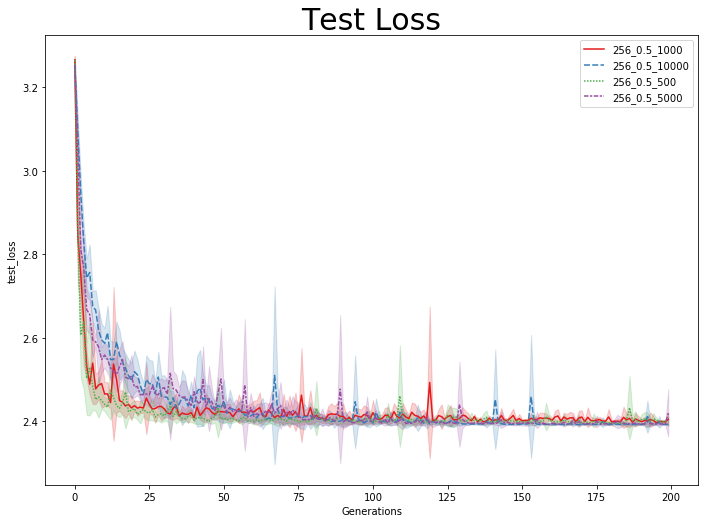

In [37]:
plot_metric(iters_dict)

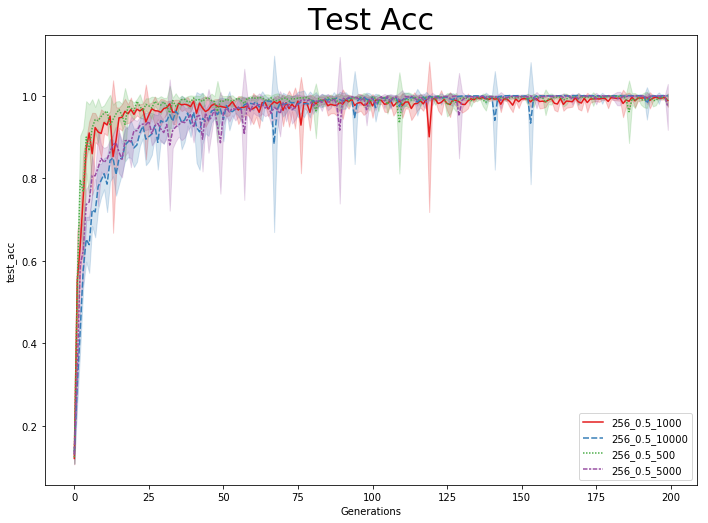

In [38]:
plot_metric(iters_dict, metric='test_acc')

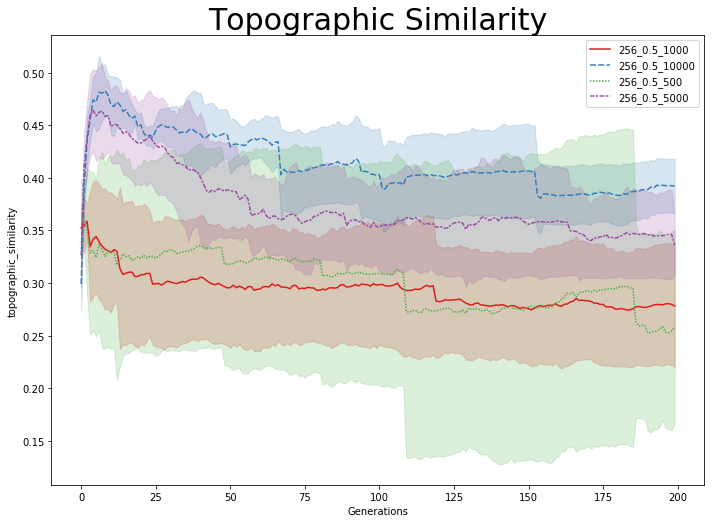

In [39]:
plot_metric(iters_dict, metric='topographic_similarity')

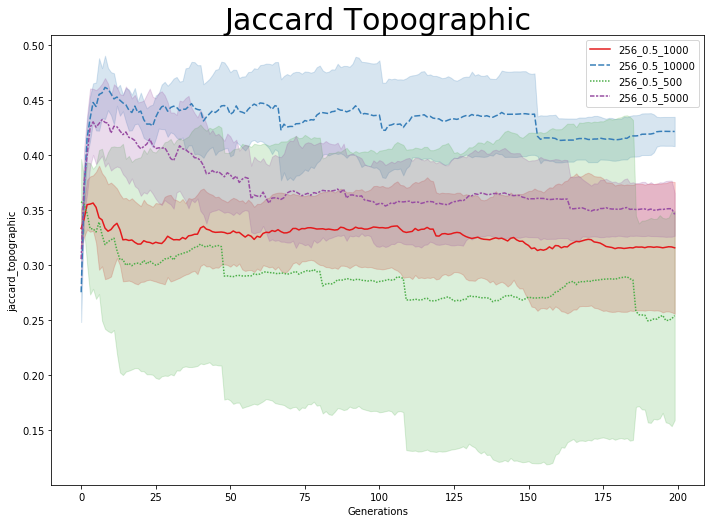

In [40]:
plot_metric(iters_dict, metric='jaccard_topographic')

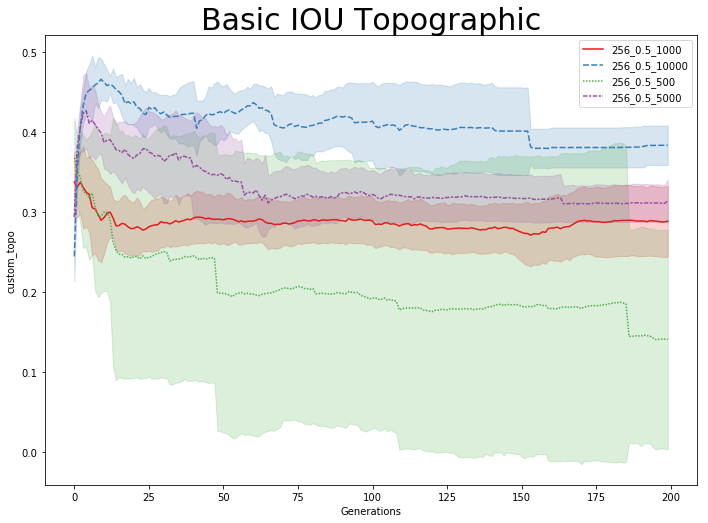

In [41]:
plot_metric(iters_dict, metric='custom_topo', title="Basic IOU Topographic")

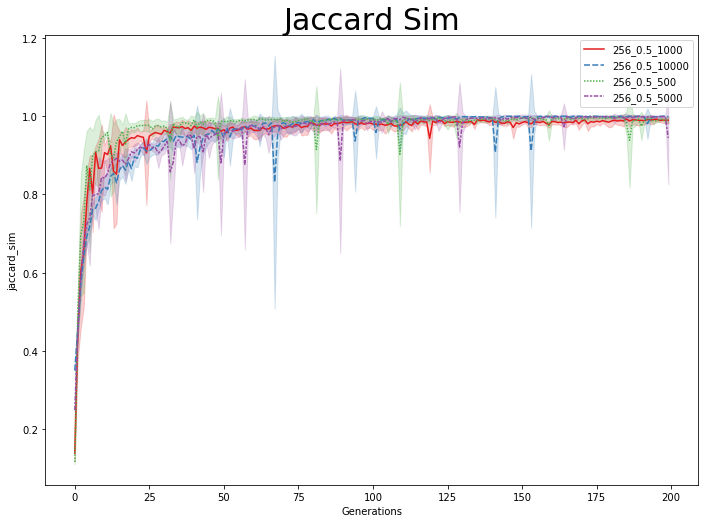

In [18]:
plot_metric(iters_dict, metric='jaccard_sim')

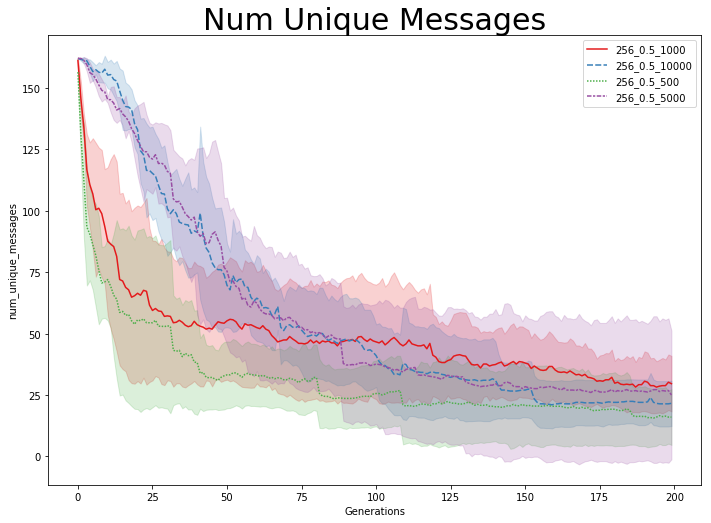

In [81]:
plot_metric(iters_dict, metric='num_unique_messages')

This shows that larger iterations do promote overfitness on the train set and therefore take longer to lead to the over simplification of language. However even with a large iteration number the models will still tend towards a minimal message count - indicating that they are ignoring inputs.

## Plot Hidden Size Results

In [42]:
def get_hidden_keys(a):
    keys = []
    for k in a:
        attributes = k.split('_')
        if float(attributes[1]) == 0.5 and int(attributes[2]) == 1000:
            keys.append(k)
    return keys

hidden_dict = { k: metrics[k] for k in get_hidden_keys(list(metrics.keys()))}

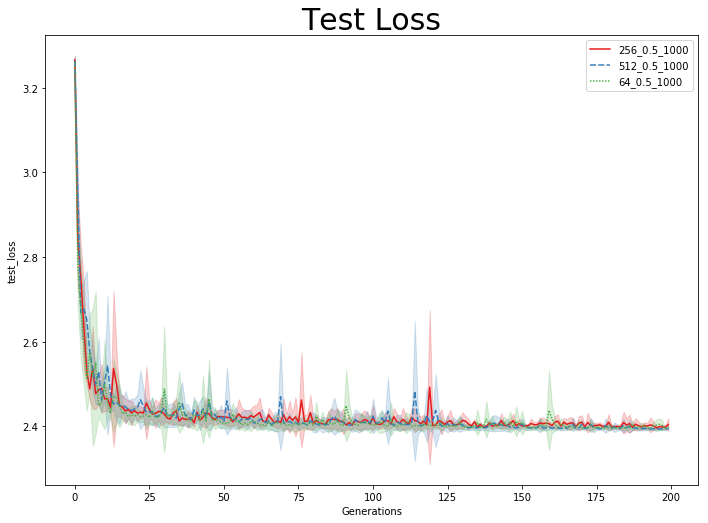

In [43]:
plot_metric(hidden_dict)

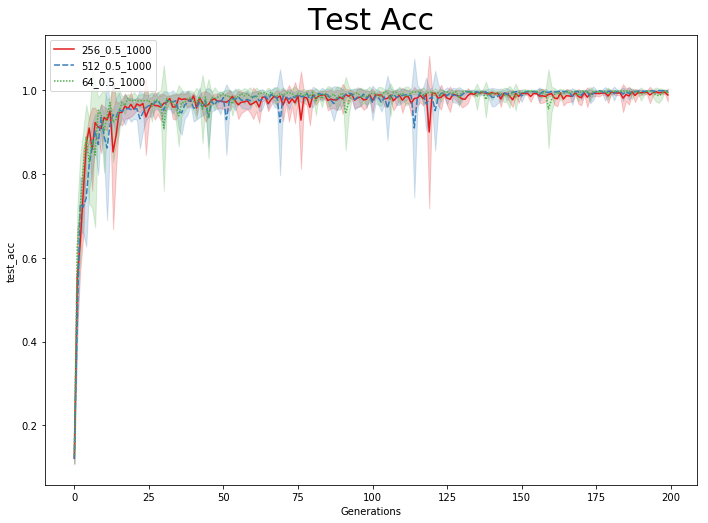

In [44]:
plot_metric(hidden_dict, metric='test_acc')

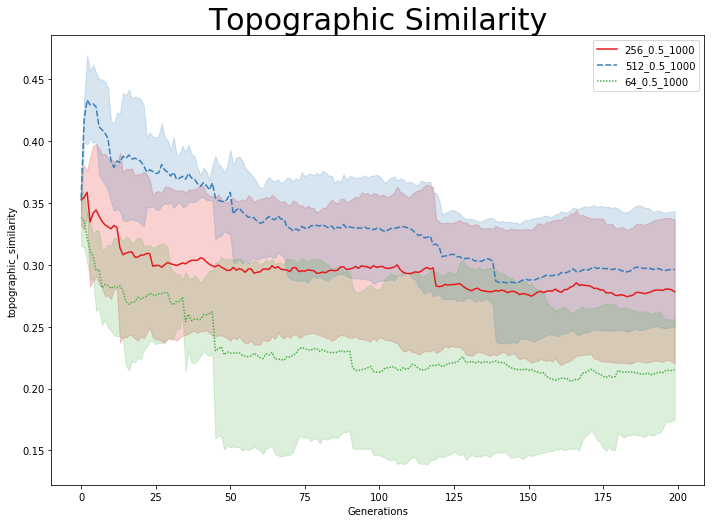

In [45]:
plot_metric(hidden_dict, metric='topographic_similarity')

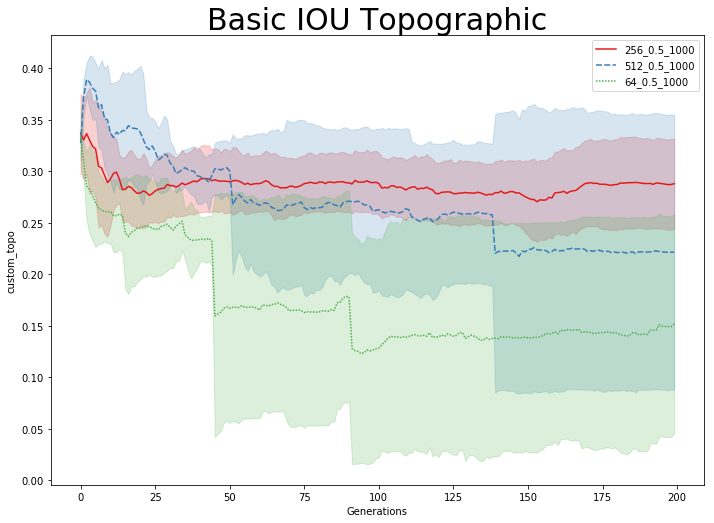

In [47]:
plot_metric(hidden_dict, metric='custom_topo', title="Basic IOU Topographic")

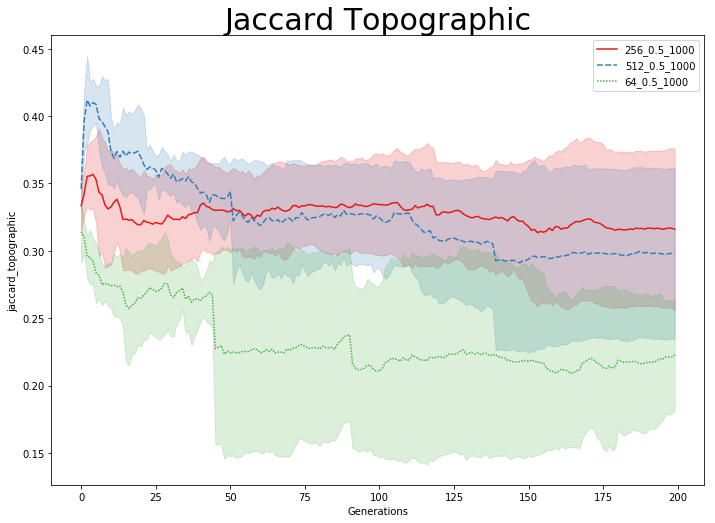

In [46]:
plot_metric(hidden_dict, metric='jaccard_topographic')

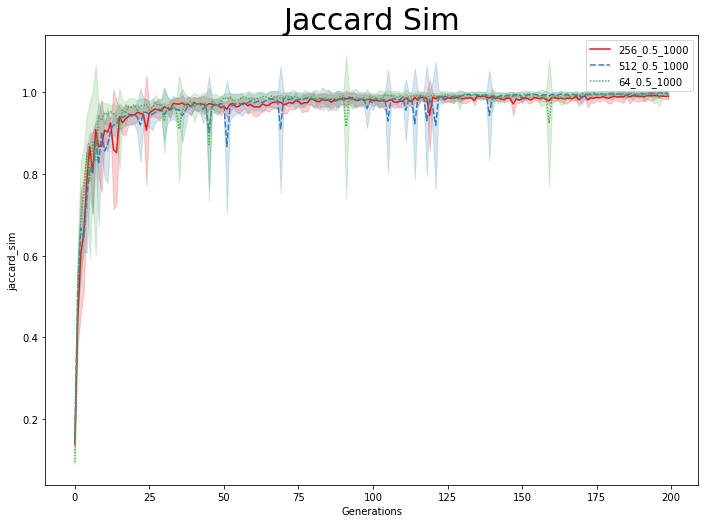

In [23]:
plot_metric(hidden_dict, metric='jaccard_sim')

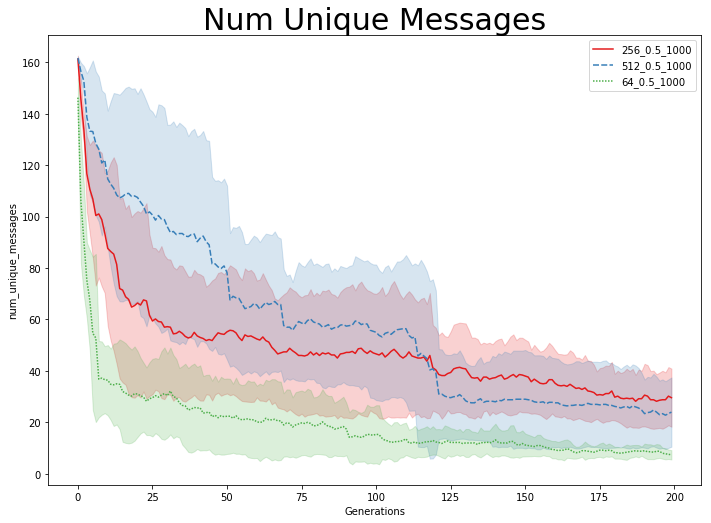

In [24]:
plot_metric(hidden_dict, metric='num_unique_messages')

Similarly to the effects of additional iterations, this shows that larger hidden size do promote overfitness on the train set and therefore take longer to lead to the over simplification of language. However the models will still tend towards a minimal message count - indicating that they are ignoring inputs.